In [1]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from regression_utils import *
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
# convention followed in relation to scikit documentation 
# y = countryQuantity 
# y1 = countryQuantityTrain
# Y = countryQuantityTest
# y_pred = countryQuantityPredict

# X = countryQuantity2 
# X1 = countryQuantity2Train
# x_mis = countryQuantity2Test
# x = countryQuantity2Predict

# c = combinedZip

In [3]:
#reading data from csv 
df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')
df.fillna(df.mean(), inplace=True)

# change here 
country = 'Germany'

# extract dataframe for selected country
%store -r countryDataFrame

# Feature 1 
countryQuantity = 'life_expectancy'

#np.random.seed(5)
split = np.random.randint(1,10)/10
print('Train:Test split is: ', split, ':',round(1-split,1))
# train test split
randomRowsTrain = countryDataFrame.sample(frac=split)
randomRowsTest = countryDataFrame.loc[~countryDataFrame.index.isin(randomRowsTrain.index)]

# train test split row numbers (to keep record of train test split in order to aid plotting)
rowTrain = list(randomRowsTrain['year'].get_values())
rowTest = list(randomRowsTest['year'].get_values())

# extract data (countryQuantity) from dataframe depending on the train test split 
countryQuantityTrain = columnExtractor(randomRowsTrain, countryQuantity)
countryQuantityTest = columnExtractor(randomRowsTest, countryQuantity)

# extract data (allFeatures) from dataframe depending on the train test split 
desiredFeatures = [#'adult_mortality', 
                   #'infant_deaths', 
                   #'alcohol',
                   'percentage_expenditure',
                   #'hepatitis_b',
                   #'measles',
                   #'bmi',
                   'under-five_deaths',
                   #'polio',
                   #'total_expenditure', 
                   #'diphtheria',
                   #'hiv/aids',
                   #'gdp',
                   #'population',
                   'thinness_10-19_years',
                   #'thinness_5-9_years',
                   #'income_composition_of_resources',
                   #'schooling',
                   'year']

allFeaturesTrain = variableColumnExtractor(randomRowsTrain, desiredFeatures)
allFeaturesTest = variableColumnExtractor(randomRowsTest, desiredFeatures)

Train:Test split is:  0.6 : 0.4


In [4]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness 1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

[(2000, 15.244352825752419, 31.017659134361317), (2004, 18.49578447009624, 30.748374098455706), (2006, 0.03291157679841114, 31.622773871341852), (2008, 0.000174306105120017, 31.62277660158037), (2009, 87.01303946033747, 14.403158555055164), (2011, 85.40912407922491, 0.8485877288629646)]


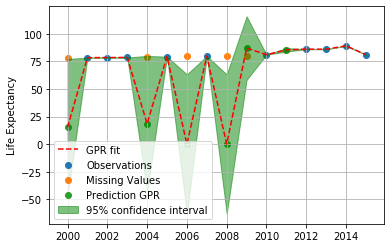

[31.0, 30.7, 31.6, 31.6, 14.4, 0.8]
[62.   0.   0.   0.  61.4  0.  63.2  0.  63.2 28.8  0.   1.6  0.   0.
  0.   0. ]
[ 77.2  78.3  78.4  78.5  79.9  79.2  63.2  79.8  63.2 115.8  81.   87.
  86.   86.   89.   81. ]
[15.2 78.3 78.4 78.5 18.5 79.2  0.  79.8  0.  87.  81.  85.4 86.  86.
 89.  81. ]
[-46.8  78.3  78.4  78.5 -42.9  79.2 -63.2  79.8 -63.2  58.2  81.   83.8
  86.   86.   89.   81. ]


In [5]:
##Gaussian regression analysis 
lengthScale = np.random.randint(10, 50) 
#print('lengthscale is: \n',lengthScale)
kernel = C(1.0, (1e-3, 1e3)) * RBF(lengthScale, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(allFeaturesTrain, countryQuantityTrain)
countryQuantityPredict, sigma = gp.predict(allFeaturesTest, return_std=True)

predictValGPR = list(zip(rowTest, list(countryQuantityPredict), list(sigma)))
predictValGPR.sort()
print(predictValGPR)

trainVal = list(zip(rowTrain, list(countryQuantityTrain)))
trainVal.sort()
#print(trainVal)

valGPR = trainVal + predictValGPR
valGPR.sort(key = lambda x: x[0])

year, age = zip(*valGPR)
#print(age)   #final life expectancy distribution 
#print(valGPR)

countryQuantity2, GPR = zip(*valGPR)

plt.plot(countryQuantity2, GPR,'--',color='r',label='GPR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredict,label='Prediction GPR') 

countryQuantityPredict = countryQuantityPredict[::-1] 
sigma = sigma[::-1]


test_list = rowTest
#print(test_list)

orderedSigma = list() 
counter = 0

for x in range(2000,2016): 
    if x in test_list: 
        orderedSigma.append(predictValGPR[counter][2])
        counter += 1
    else : 
        orderedSigma.append(0)
    
        
sigma = [round(elem, 1) for elem in sigma]
#print(orderedSigma)
orderedSigma = [round(elem, 1) for elem in orderedSigma]
orderedSigma = [2*x for x in orderedSigma]
#print(orderedSigma)

age = [round(elem, 1) for elem in age]
age = np.asarray(age)


orderedSigma = np.asarray(orderedSigma)


positive = age + orderedSigma
negative = age - orderedSigma



plt.fill_between(np.linspace(np.min(countryDataFrame['year'].values),
                             np.max(countryDataFrame['year'].values),
                             16), 
                     positive, 
                     (negative), 
                     color='green',alpha=0.5,label='95% confidence interval')
plt.ylabel('Life Expectancy')
plt.grid()
plt.legend()
plt.show()

print(sigma)
print(orderedSigma)
print(positive)
print(age)
print(negative)


[84.15737351 80.86791836 80.24950227 80.19768561 79.65453855 77.03862358]


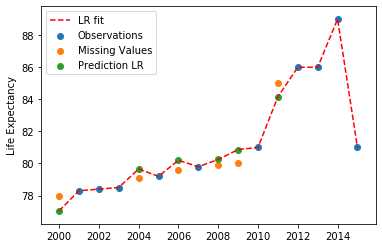

In [6]:
#Linear regression analysis 
regr = linear_model.LinearRegression()
regr.fit(allFeaturesTrain, countryQuantityTrain)

countryQuantityPredictLR = regr.predict(allFeaturesTest)
print(countryQuantityPredictLR)

predictValLR = list(zip(rowTest, list(countryQuantityPredictLR)))
predictValLR.sort()

valLR = trainVal + predictValLR
valLR.sort(key = lambda x: x[0]) 

years, LR = zip(*valLR)

plt.plot(years, LR,'--',color='r',label='LR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredictLR,label='Prediction LR')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

In [7]:
# error computation for GPR 
groundTruth = countryDataFrame[countryQuantity].get_values()[::-1]
print('groundTruth values \n',groundTruth)

GPR = [round(float(i),1) for i in list(GPR)]
print('GPR prediction \n',GPR)

print('------------------------------------------')

errorGPR = np.sqrt(mean_squared_error(groundTruth, GPR))

# error computation for LR 
LR = [round(float(i),1) for i in list(LR)]
print('LR prediction \n',LR) 

errorLR = np.sqrt(mean_squared_error(groundTruth, LR))
print('GPR error \n',errorGPR, '%')
print('LR error \n',errorLR, '%')

#go with rmse for outliers 
#try using normalization

groundTruth values 
 [78.  78.3 78.4 78.5 79.1 79.2 79.6 79.8 79.9 80.  81.  85.  86.  86.
 89.  81. ]
GPR prediction 
 [15.2, 78.3, 78.4, 78.5, 18.5, 79.2, 0.0, 79.8, 0.0, 87.0, 81.0, 85.4, 86.0, 86.0, 89.0, 81.0]
------------------------------------------
LR prediction 
 [77.0, 78.3, 78.4, 78.5, 79.7, 79.2, 80.2, 79.8, 80.2, 80.9, 81.0, 84.2, 86.0, 86.0, 89.0, 81.0]
GPR error 
 35.69447611325876 %
LR error 
 0.45138675213169643 %


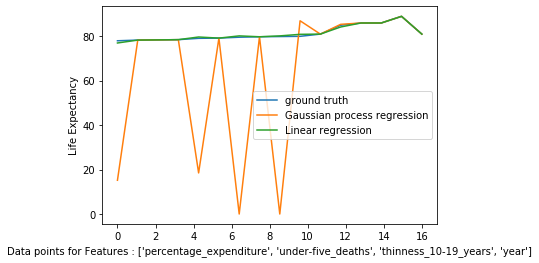

In [8]:
#comparing lr, gpr and groundtruth 

plt.ylabel('Life Expectancy')
plt.xlabel('Data points for Features : %s'%(desiredFeatures))
plt.plot(np.linspace(0,16,16), groundTruth, label='ground truth')
plt.plot(np.linspace(0,16,16), GPR, label = 'Gaussian process regression')
plt.plot(np.linspace(0,16,16), LR, label = 'Linear regression')
plt.legend()

In [9]:
#https://yugeten.github.io/posts/2019/09/GP/
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpr-co2-py
#https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/statistical_inference/supervised_learning.html